This notebook is to impute missing data on features.

# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Define functions

In [2]:
# Define function for missing clarification
def del_missing(df,col_name):
    '''Check distribution of death rate without missing data. 
    col_name = column of missing data'''
    non_missing_crit = df[col_name].notnull()
    non_missing_df = df[non_missing_crit]
    diff = round(round(non_missing_df.hospital_death.mean()*100,2) - round(df.hospital_death.mean()*100,2),2)
    print('If delete missing records in '+ col_name +': ')
    if diff <0:
        print('The percentage of death in the new data set is ' + str(diff)+'% lower than train_df.')
    else:
        print('The percentage of death in the new data set is ' + str(diff)+'% higher than train_df: ' + str(round(non_missing_df.hospital_death.mean()*100,2))+'%.')
    

In [3]:
# Define feature function
def plot_feature(df, col):
    '''
    make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of death on the feature'''
    plt.figure(figsize = (14,6))
    plt.subplot(1,2,1)
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
        plt.xticks(rotation=45)
    else:
        mean=df.groupby(col)['hospital_death'].mean()
        df[col]=df[col].astype('category') 
        levels=mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels,inplace=True)
        df[col].value_counts().plot()
        #plt.xticks(levels,rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.title('Distribution of '+col)
    
    plt.subplot(1,2,2)   
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        mean_x=df.groupby(col)['hospital_death'].mean()
        mean_x.plot()
        plt.xticks(rotation=45)
    else:
        mean_x=df.groupby(col)['hospital_death'].mean().sort_values()
        levels=mean_x.sort_values().index.tolist()
        plt.scatter(mean_x.sort_values().index,mean_x)
        plt.xticks(levels,rotation=45) 
    plt.xlabel(col)
    plt.ylabel('Percent of death')
    plt.title('Percent of death by '+col)
    plt.show()

# Import data set

In [4]:
train_df=pd.read_csv('train_df.csv',index_col=0)

In [5]:
## identify categorical variables
#for col in train_df.columns.to_list():
#    if train_df[col].dtype == 'object':
#        train_df[col]=train_df[col].astype('category')
#train_df.to_csv('train_df.csv')

In [6]:
# generate new df of selected vars:
int_cols_selected = ['elective_surgery','apache_post_operative']
numeric_cols_selected = ['age', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'd1_diasbp_min', 'd1_diasbp_noninvasive_min', 'd1_mbp_min', 'd1_mbp_noninvasive_min', 'd1_sysbp_min', 'd1_sysbp_noninvasive_min', 'h1_diasbp_noninvasive_min', 'h1_mbp_min', 'h1_mbp_noninvasive_min', 'h1_sysbp_min', 'h1_sysbp_noninvasive_min', 'd1_calcium_min','d1_calcium_max', 'albumin_apache', 'd1_albumin_max', 'd1_albumin_min']
categorical_cols_selected = ['ethnicity','gender','icu_admit_source','hospital_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']

var_list = ['hospital_death'] + int_cols_selected + numeric_cols_selected + categorical_cols_selected

train_df_miss = train_df[var_list]
train_df_miss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91713 entries, 0 to 91712
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hospital_death             91713 non-null  int64  
 1   elective_surgery           91713 non-null  int64  
 2   apache_post_operative      91713 non-null  int64  
 3   age                        87485 non-null  float64
 4   gcs_eyes_apache            89812 non-null  float64
 5   gcs_motor_apache           89812 non-null  float64
 6   gcs_verbal_apache          89812 non-null  float64
 7   d1_diasbp_min              91548 non-null  float64
 8   d1_diasbp_noninvasive_min  90673 non-null  float64
 9   d1_mbp_min                 91493 non-null  float64
 10  d1_mbp_noninvasive_min     90234 non-null  float64
 11  d1_sysbp_min               91554 non-null  float64
 12  d1_sysbp_noninvasive_min   90686 non-null  float64
 13  h1_diasbp_noninvasive_min  84363 non-null  flo

All 'float64' and 'object' columns have missing values. 

# Missing data

### Step 1: Indentify missing values, convert all to null. 

This step is completed before EDA. 

### Step 2: Analyze the missingness in data

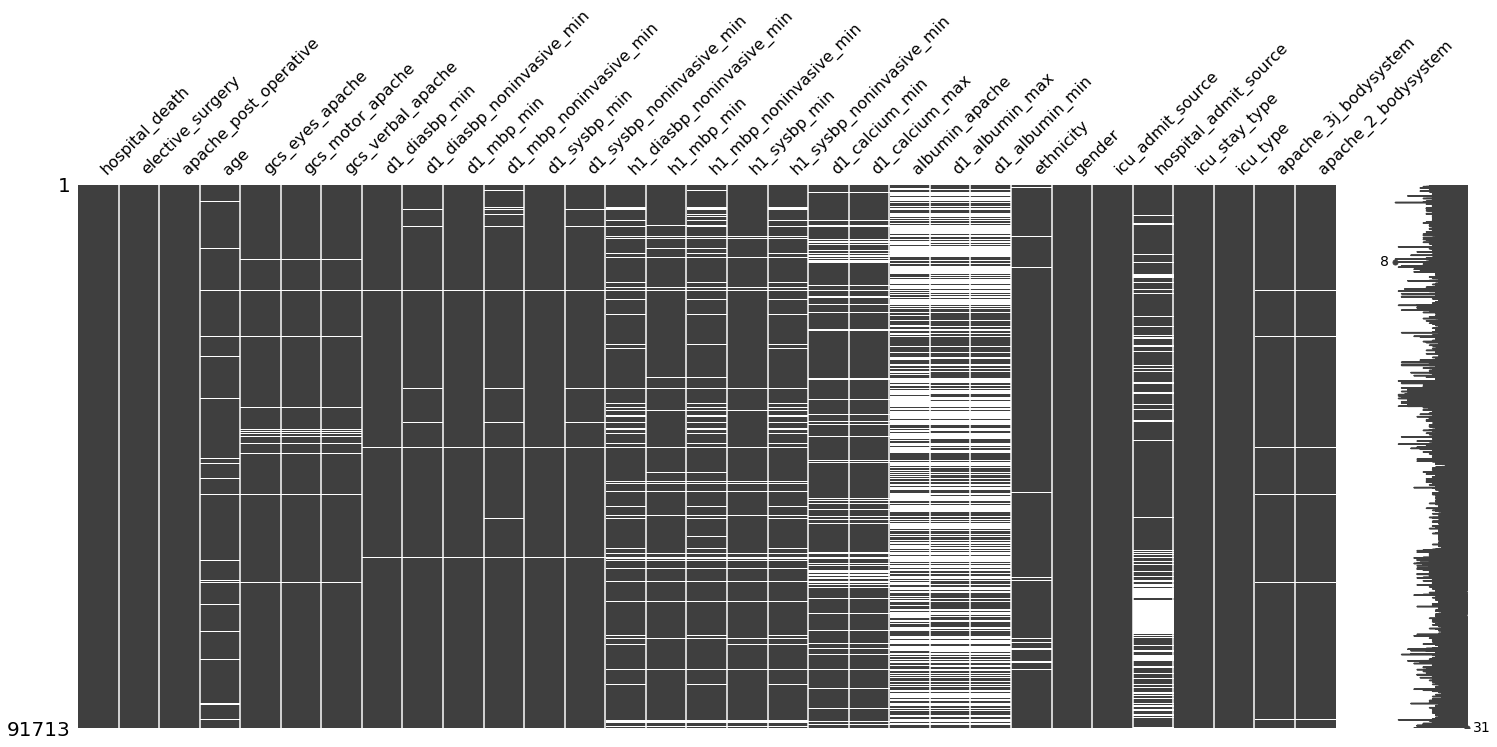

In [7]:
# Understanding missing patterns in all columns
msno.matrix(train_df_miss)
plt.show()

Missing values in the data set have various patterns across columns. 

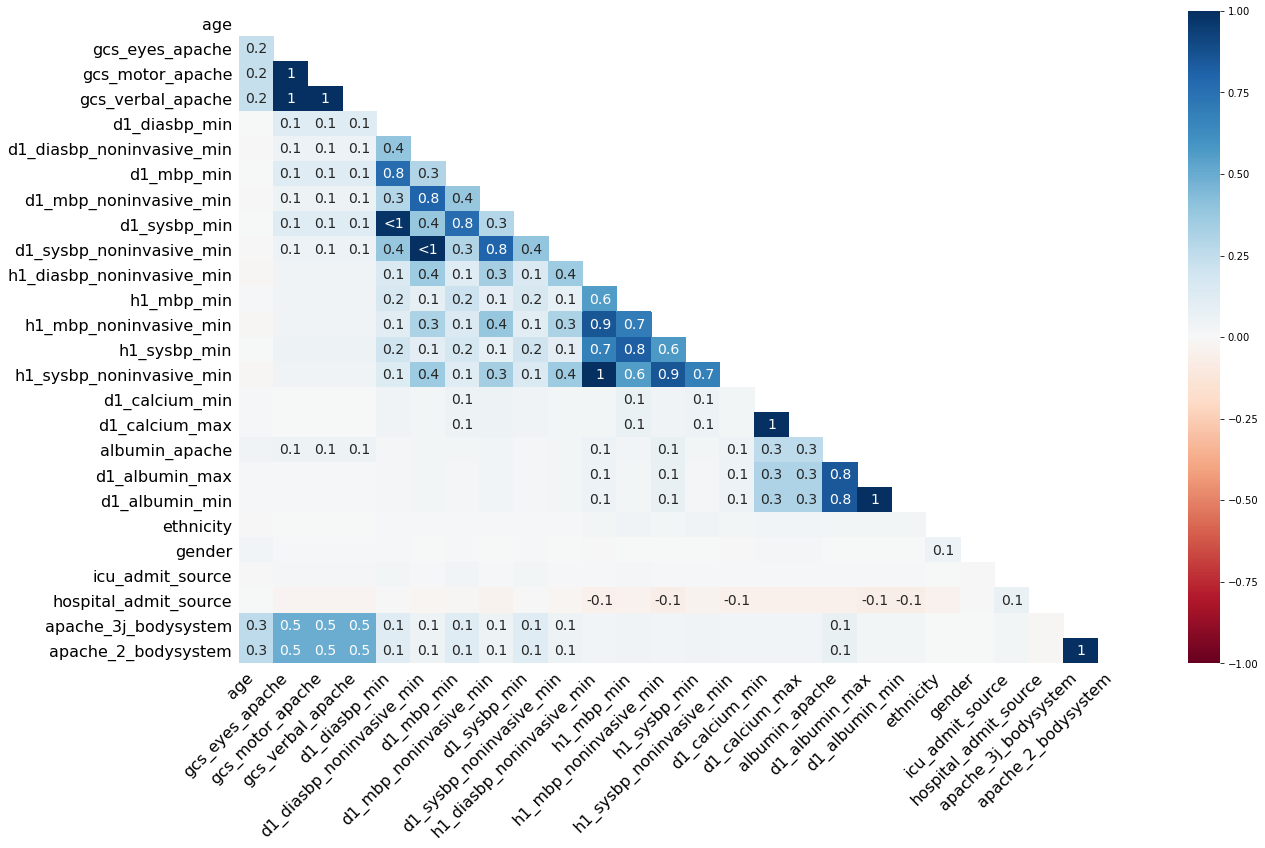

In [8]:
# Correlation in number of missing values between columns
msno.heatmap(train_df_miss)
plt.show()

#if red color: mcar
#if blue color: mnar

A lot of blue columns in the heatmap also shows that the missing values across columns are more or less related to each other. 

Therefore, it's likely that most missing values are not missing at random. Imputation is considered to save these observations. 

In [9]:
# Generate a new table to calculate the amount / % and type of missingness in data
missing_percent = pd.DataFrame(train_df_miss.apply(lambda col:sum(col.isnull())/col.size*100),columns=['percent'])
missing_type = pd.DataFrame(train_df_miss.apply(lambda col:col.dtype),columns=['type'])
missing_table = pd.concat([missing_type,missing_percent],axis=1)

missing_columns = missing_table[missing_table['percent']!=0]
#categorize random types for columns of missing values
#missing['random_type']=pd.cut(missing['percent'], bins=[-1, 0, 10, 20, 100], include_lowest=False, labels=['no missing', 'missing completely at random', 'missing at random','missing not at random'])

missing_columns


,type,percent
age,object,4.610033
gcs_eyes_apache,object,2.072770
gcs_motor_apache,object,2.072770
gcs_verbal_apache,object,2.072770
d1_diasbp_min,object,0.179909
d1_diasbp_noninvasive_min,object,1.133972
d1_mbp_min,object,0.239879
d1_mbp_noninvasive_min,object,1.612639
d1_sysbp_min,object,0.173367
d1_sysbp_noninvasive_min,object,1.119798


### Step 3: Whether deleting var will affect hospital death rate?

In [10]:
for col in missing_columns.index.tolist():
    del_missing(train_df_miss,col)

If delete missing records in age: 
The percentage of death in the new data set is -0.32% lower than train_df.
If delete missing records in gcs_eyes_apache: 
The percentage of death in the new data set is -0.18% lower than train_df.
If delete missing records in gcs_motor_apache: 
The percentage of death in the new data set is -0.18% lower than train_df.
If delete missing records in gcs_verbal_apache: 
The percentage of death in the new data set is -0.18% lower than train_df.
If delete missing records in d1_diasbp_min: 
The percentage of death in the new data set is -0.02% lower than train_df.
If delete missing records in d1_diasbp_noninvasive_min: 
The percentage of death in the new data set is -0.02% lower than train_df.
If delete missing records in d1_mbp_min: 
The percentage of death in the new data set is -0.01% lower than train_df.
If delete missing records in d1_mbp_noninvasive_min: 
The percentage of death in the new data set is 0.0% higher than train_df: 8.63%.
If delete missing

Apparently, albumin_apache, d1_albumin_max,d1_albumin_min are affecting hospital_death more than other vars. 

Proper imputation for these three columns is to be tested. 

# Imputation

### Mean imputation for numeric data

In [11]:
train_df_float_meanimpute=train_df_miss.loc[:,train_df_miss.dtypes == 'float64'].copy(deep=True)
mean_imputer = SimpleImputer(strategy='mean')  # create mean imputer
train_df_float_meanimpute.iloc[:, :] = mean_imputer.fit_transform(train_df_float_meanimpute)

train_df_float_meanimpute=pd.concat([train_df_miss.iloc[:,0:3],train_df_float_meanimpute], axis=1)

train_df_float_meanimpute.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 91713 entries, 0 to 91712
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hospital_death             91713 non-null  int64  
 1   elective_surgery           91713 non-null  int64  
 2   apache_post_operative      91713 non-null  int64  
 3   age                        91713 non-null  float64
 4   gcs_eyes_apache            91713 non-null  float64
 5   gcs_motor_apache           91713 non-null  float64
 6   gcs_verbal_apache          91713 non-null  float64
 7   d1_diasbp_min              91713 non-null  float64
 8   d1_diasbp_noninvasive_min  91713 non-null  float64
 9   d1_mbp_min                 91713 non-null  float64
 10  d1_mbp_noninvasive_min     91713 non-null  float64
 11  d1_sysbp_min               91713 non-null  float64
 12  d1_sysbp_noninvasive_min   91713 non-null  float64
 13  h1_diasbp_noninvasive_min  91713 non-null  flo

In [12]:
# Evaluate the performance of impuated data set. 

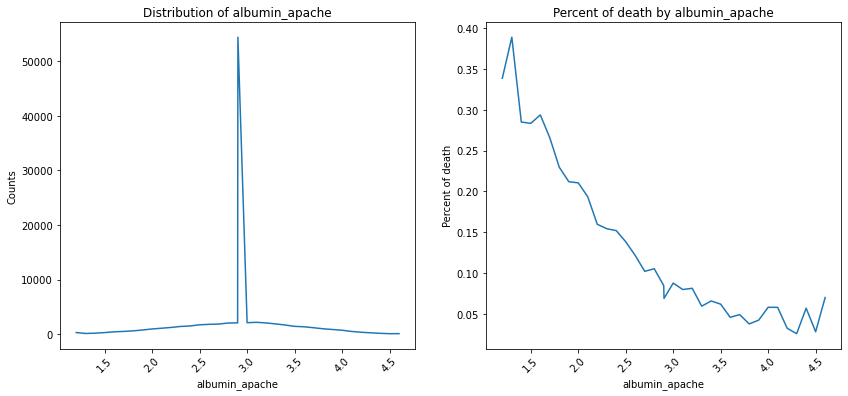

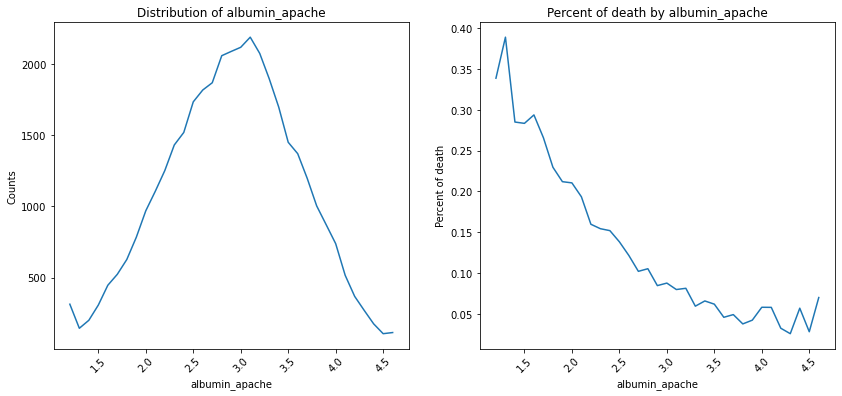

In [13]:
# feature before & after imputation
plot_feature(train_df_float_meanimpute,'albumin_apache')
plot_feature(train_df_miss,'albumin_apache')


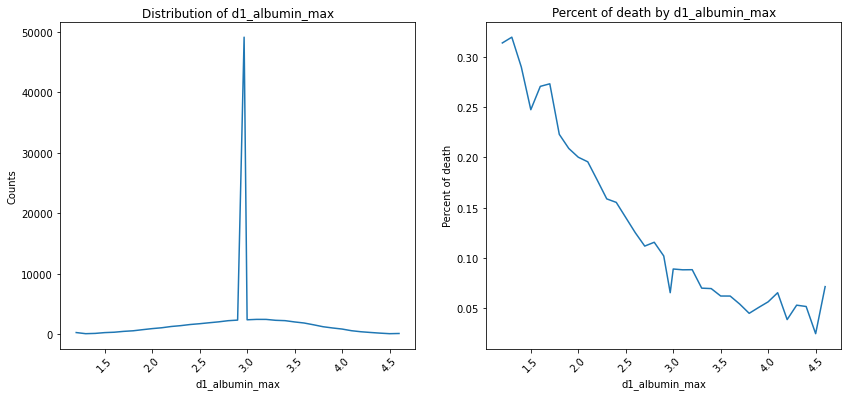

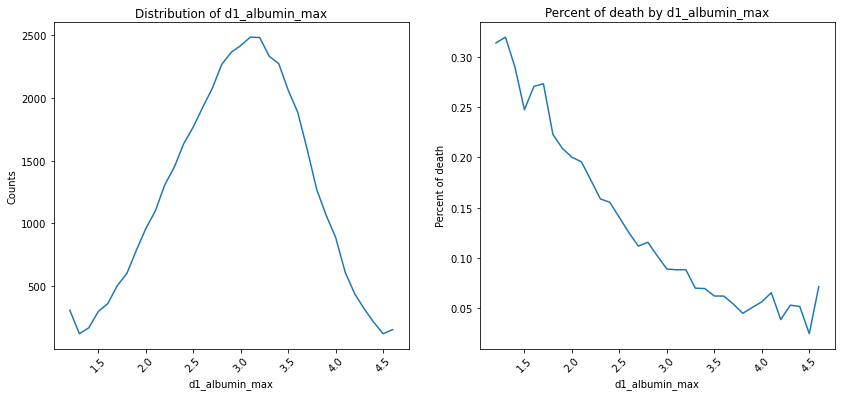

In [14]:
# feature before & after imputation
plot_feature(train_df_float_meanimpute,'d1_albumin_max')
plot_feature(train_df_miss,'d1_albumin_max')


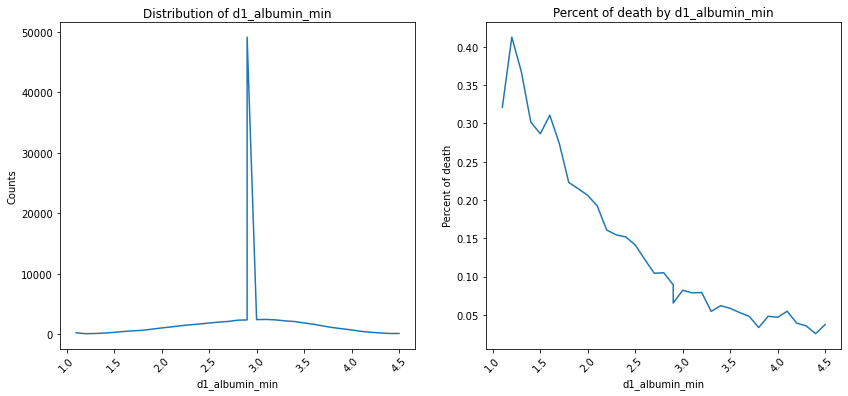

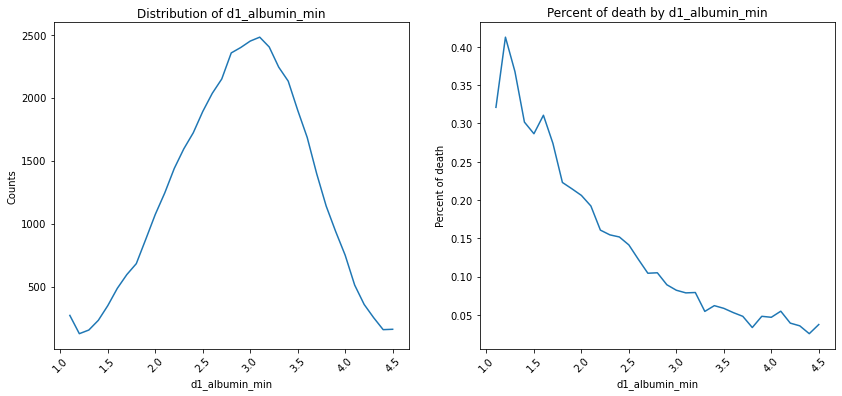

In [15]:
# feature before & after imputation
plot_feature(train_df_float_meanimpute,'d1_albumin_min')
plot_feature(train_df_miss,'d1_albumin_min')


### KNN imputation for numeric data

In [16]:
from fancyimpute import KNN

In [ ]:
conda install -c conda-forge keras 
conda install -c conda-forge cvxpy
conda install -c conda-forge cvxopt
conda install -c conda-forge scikit-learn
conda install -c conda-forge numpy
conda install -c conda-forge scipy
conda install -c conda-forge knnimpute

In [ ]:
train_df_float_knnimpute=train_df_miss.loc[:,train_df_miss.dtypes == 'float64'].copy(deep=True)
knn_imputer = KNN()

train_df_float_knnimpute.iloc[:, :] = knn_imputer.fit_transform(train_df_float_knnimpute)

train_df_float_knnimpute.info(verbose=True, null_counts=True)


In [ ]:
# Evaluate the performance of impuated data set. 

In [ ]:
# feature before & after imputation
plot_feature(train_df_float_knnimpute,'albumin_apache')
plot_feature(train_df_miss,'albumin_apache')


In [ ]:
# feature before & after imputation
plot_feature(train_df_float_knnimpute,'d1_albumin_max')
plot_feature(train_df_miss,'d1_albumin_max')


In [ ]:
# feature before & after imputation
plot_feature(train_df_float_knnimpute,'d1_albumin_min')
plot_feature(train_df_miss,'d1_albumin_min')


### KNN imputation for categorical data

In [ ]:
# Create Ordinal Encoder in a loop
train_df_object_KNNimpute = train_df_miss.loc[:,train_df_miss.dtypes == 'object'].copy(deep=True)

ordinal_enc_dict = {}
for col_name in train_df_object_KNNimpute:
    ordinal_enc_dict[col_name] = OrdinalEncoder()
    
    # Select non-null values in ethnicity
    col = train_df_object_KNNimpute[col_name]
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1,1)
    
    #Encode the non-null values of ethnicity
    encoded_vals=ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
    #replace df with ordinal values
    train_df_object_KNNimpute.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)
    

In [ ]:
#impute in the Ordinal df using K-Nearest Neighbors(KNN)
KNN_imputer = KNN()
train_df_object_KNNimpute.iloc[:, :] = np.round(KNN_imputer.fit_transform(train_df_object_KNNimpute))

for col_name in train_df_object_KNNimpute:
    reshaped = train_df_object_KNNimpute[col_name].values.reshape(-1,1)
    # convert back from ordinal values to categorical values
    train_df_object_KNNimpute[col_name] = ordinal_enc_dict[col_name].inverse_tranform(reshaped)


In [ ]:
# Evaluate the performance of impuated data set. 

In [ ]:
# feature before & after imputation
plot_feature(train_df_object_KNNimpute,'albumin_apache')
plot_feature(train_df_miss,'albumin_apache')


In [ ]:
# feature before & after imputation
plot_feature(train_df_object_KNNimpute,'d1_albumin_max')
plot_feature(train_df_miss,'d1_albumin_max')


In [ ]:
# feature before & after imputation
plot_feature(train_df_object_KNNimpute,'d1_albumin_min')
plot_feature(train_df_miss,'d1_albumin_min')


In [16]:
train_df_float_meanimpute.to_csv('train_df_imputed.csv')